# Solving the Malthus model

Modelproject by Josefine Pedersen, Viktor Texel and Pernille Svendsen

> **Table of content:** 
> 1. Model description
> 1. Analytical solution
> 1. Numerical solution
> 1. Further analysis
> 1. Extension of the model
> 1. Conclusion




*Imports and set magics*

In [1]:
import numpy as np
from scipy import optimize
import sympy as sm
from types import SimpleNamespace
import ipywidgets as widgets # For interactive plots/buttons

# plotting
import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject as mp

# Model description

We consider the **standard Malthus model**. We assume discrete time, $t\in\{0,1,\dots\}$ and a closed economy. Therefore, total production equals income. 

An assumption in the Malthus model is that labor is subject to diminishing returns in production. We model this with a **Cobb-Douglas production function**:

$$
Y_{t}=L_{t}^{1-\alpha}(AX)^{\alpha}
$$

Where: 
1. $L_t$ is labor (we assume no unemployment)
3. $A$ is technology (constant over time)
4. $X$ is land (constant over time)
5. $Y_t$ = is GDP (production). This is equal to income.

Since we have assumed no unemployment **the size of the labor force will equal total population**.

Given that this is a Malthus model, technology is **constant over time** and can thus only grow through shocks.



**Output pr. worker** is given by:

$$
y_{t}=\left(\frac{AX}{L_t}\right)^{\alpha}
$$

Since $\alpha<1$ (diminishing returns) we have that as L increases, output per worker declines, given that AX is constant.

**Household preferences** are given by:

$$
u_{t} = \beta \log (c_{t}) + (1-\beta) \log (n_{t}), \ \ \ 0<\beta<1
$$

Where: 
1. $c_t$ is consumption
3. $n_t$ is the number of children

And the **budget constraint** is given by:

$$
y_{t} ≥ \lambda n_{t} + c_{t}
$$

The size of the labor force evolves according to:

$$
L_{t+1} = n_{t}L_{t}+(1-\mu)L_{t}, \ \ \ L_{0} \ given
$$

The above equation implies that $\mu$ represents mortality.

The **law of motion for the labor force** will therefore be given by:

$$
L_{t+1} = \left(\frac{1-\beta}{\lambda} \right) L_{t}^{1-\alpha}(AX)^{\alpha}+(1-\mu)L_{t}, \ \ \ L_{0} \ given
$$

## Analytical solution

In [2]:
# Parameters
mu, beta, lamb, alpha = sm.symbols('mu beta lambda alpha')

# Fixed variables
A, X = sm.symbols('A X')

# Variables
Yt, yt, Lt, Lt1, nt, ct, ut = sm.symbols('Y_t y_t L_t L_{t+1} n_t c_t u_t')

# Steady state variables
L_star, y_star = sm.symbols('L^* y^*')

**Household problem**

We define the household preferences and budget constraint. We assume that households use all their available income for either consumption or child rearing:

In [3]:
utility = beta*sm.log(ct)+(1-beta)*sm.log(nt)
budget = sm.Eq(yt, lamb*nt+ct)

We solve the household problem in **four steps**:

1. We **isolate** $c_t$ from the budget constraint
2. We **substitute** in $c_t$ in the utility function
3. We **take the derivative** wrt. $n_t$
4. We **solve the FOC** for $n_t$

In [4]:
# isolate consumption
ct_from_budget = sm.solve(budget, ct)

# substitute into the budget constraint
utility_subs = utility.subs(ct, ct_from_budget[0])

# take the derivattive w.r.t. number of children
foc = sm.diff(utility_subs, nt)

# solving the FOC for optimal number of children
sol = sm.solve(sm.Eq(foc,0), nt)[0]
sol

y_t*(1 - beta)/lambda

The above expression determines the optimal number of children for the household. Here we see that the preference for children increases when there is a cultural valuation for having more children (hence $(1-\beta)$ is larger) as well as when the cost of having children is lower (lower $\lambda$).

**Law of motion for labor**

Below we find the steady state level for the labor force given the law of motion:

In [5]:
# Law of motion
LOM = sm.Eq(Lt1, ((1-beta)/lamb)*Lt**(1-alpha)*(A*X)**alpha+(1-mu)*Lt)
LOM

Eq(L_{t+1}, L_t*(1 - mu) + L_t**(1 - alpha)*(A*X)**alpha*(1 - beta)/lambda)

To find the steady state value for the labor force we:
1. **Substitute**, such that $L^* = L_{t} = L_{t+1}$ 
2. **Solve** for $L^*$:

In [6]:
# Substitute for L*
SS = sm.Eq(L_star, ((1-beta)/lamb)*L_star**(1-alpha)*(A*X)**alpha+(1-mu)*L_star)

# Solve for L_star
L_star_sol = sm.solve(SS, L_star)[0]

# Print the solution
L_star_sol

((A*X)**alpha*(1 - beta)/(lambda*mu))**(1/alpha)

Therefore we have that population density (given when dividing by X, $\frac{L^*}{X}$) rises if:
1. The level of technology increases (A)
2. Households value children more $(1-\beta)$
3. The cost of having children decreases ($\lambda$)
3. The mortality declines ($\mu$).

We can turn the expression for steady state labor force into a Python-function to evaluate the solution:

In [7]:
ss_L_func = sm.lambdify((A,X,beta,lamb,mu,alpha),L_star_sol)
ss_L = ss_L_func(1,3,0.8,0.5,0.3,0.6)
print(f'The analytical solution for steady state labor force is: {ss_L:.2f}')

The analytical solution for steady state labor force is: 4.85


This result arises **given the chosen parameters**.

## Numerical solution

We define the **set of parameters** needed for solving the model numerically:

In [8]:
# Defining parameters
par =  SimpleNamespace()
par.beta = 0.8
par.lamb = 0.5
par.mu = 0.3
par.alpha = 0.6
par.A = 1
par.X = 3
par.T = 100   

In [9]:
obj_lss = lambda lss: lss - (((1-par.beta)/par.lamb)*lss**(1-par.alpha)*(par.A*par.X)**(par.alpha)+(1-par.mu)*lss)
mp.solve(obj_lss)

The steady state for L is: 4.85


We can see that we get the **exact same solution as the analytical solution**, if we choose the same parameter values. This is also the case if we choose different parameter values for both cases.

**Plotting the phase diagram for population**

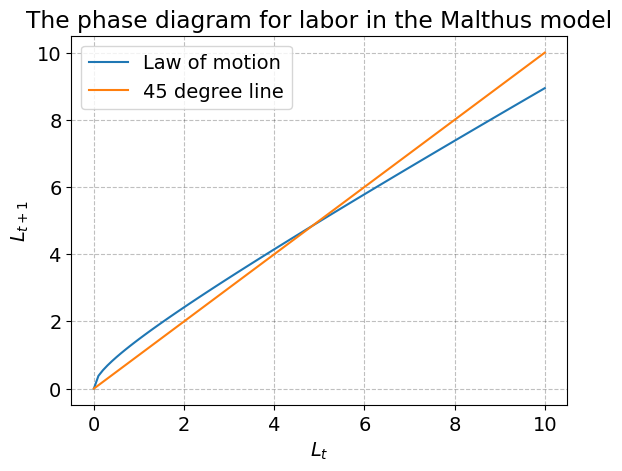

In [10]:
# Plot phase diagram
mp.phase_diagram(par)

The plot shows that the law of motion for labor crosses the 45 degree line at exactly the steady state value. This implies that labor will not increase anymore (labor in period t is equal to labor in period t+1)

**Plotting the path to convergence for the population size**

In [11]:
beta = par.beta
lamb = par.lamb
mu = par.mu
alpha = par.alpha
A_val = par.A
X_val = par.X
T_val = par.T

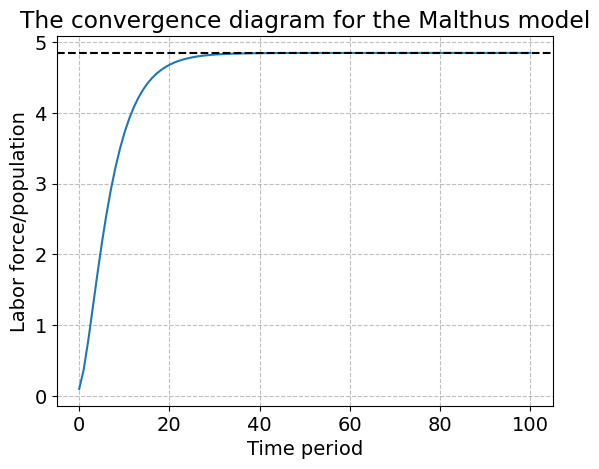

In [12]:
mp.convergence(beta,lamb,mu,alpha,A_val,X_val,T_val,interactive=False)

It can be seen by the figure, that for the chosen parameter values the model **converges to the steady state value for the labor force** (and thereby for population) in **approximately 40 time periods**.

# Further analysis

To further analyse the model, we make the convergence plot interactive, to see what happens when we change the parameter values:

In [13]:
widgets.interact(mp.convergence,
    beta=widgets.FloatSlider(description=r"beta", min=0.1, max=1, step=0.05, value=beta),
    lamb=widgets.FloatSlider(description=r"lambda", min=0.1, max=1, step=0.05, value=lamb),
    mu=widgets.FloatSlider(description=r"mu", min=0.1, max=1, step=0.05, value=mu),
    alpha=widgets.FloatSlider(description=r"alpha", min=0.1, max=1, step=0.05, value=alpha),
    A_val=widgets.FloatSlider(description=r"A", min=1, max=5, step=0.5, value=A_val),
    X_val=widgets.FloatSlider(description=r"X", min=1, max=5, step=0.5, value=X_val),
    T_val=widgets.fixed(T_val),
    interactive=widgets.fixed(True)
);

interactive(children=(FloatSlider(value=0.8, description='beta', max=1.0, min=0.1, step=0.05), FloatSlider(val…

In the above plot we can see that:
1. When $\beta$ decreases the steady state value increases, since household's thus value children more, so steady state labor force will increase. The time it takes to reach steady state does not change however.
2. When $\lambda$ increases the steady state value decreases, since household's thus have higher costs of having children, so steady state labor force will decrease. The time it takes to reach steady state does not change however.
3. When $\mu$ increases the steady state value decreases, since household's thus have a higher mortality rate, so steady state labor force will decrease. The time it takes to reach steady state is also lowered.
4. When $\alpha$ increases the steady state value decreases, since labor becomes less productive, thus income decreases and therefore household's can have fewer children. The time it takes to reach steady state is also lowered.
5. When $A$ or $X$ increase the steady state value increases, since more land can sustain more people and a higher level of techonology increases income, such that household's can have more children. The time it takes to reach steady state does not change.

Steady state will however still be reached, since e.g. technological growth leads to initially higher income, but since population also grows, income pr. worker will decrease (due to diminishing returns to scale), so growth in labor force will decrease again. 

We can see this by investigating what happens if **techology permanently increase 50 periods in the future**:

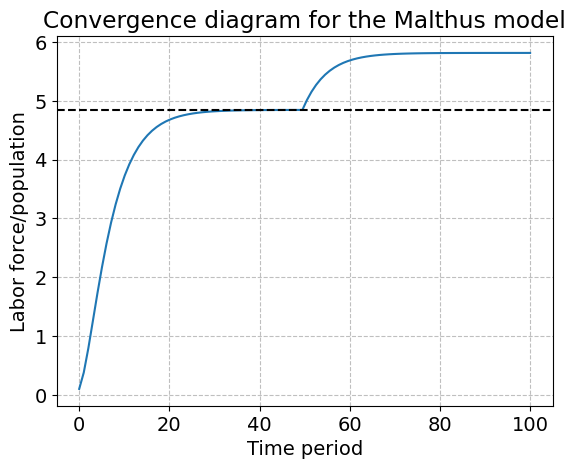

In [14]:
# Create the shock path for A
A_path = np.ones(par.T) * par.A  # start with a vector of A values equal to par.A
A_path[50:] = A_path[50:] * 1.2  # increase A by 20% from t=50 onwards

# Call the convergence function with the shock path for A
L_path = mp.convergence_tech_shock(par,A_path)

We can see that population size has converged initially after about 40 periods, but then techology increases, so the economy is momentarily pushed out of steady state, such that population increases. This is however only until the lacking income pr. worker growth induces household's to stop having more children.

# Extension of the model

We can extend the model with technological growth. 
$$
\frac{A_{t+1}}{A_{t}} = g
$$

where g is this growth factor. In the baseline model $g=1$

With technological change we get a slighty changed law of motion
$$
L_{t+1} = \eta L_{t}^{1-\alpha}(A_{t}X)^{\alpha}+(1-\mu)L_{t}, \ \ \ L_{0} \ given
$$


The evolution of the labor force (and hence population) for constant growth in techonology is plotted below. Here it can be seen, that population will now not stagnate, since progressing technology can allow for increasing income pr. worker, and thus households would continue to update their preference for having children.

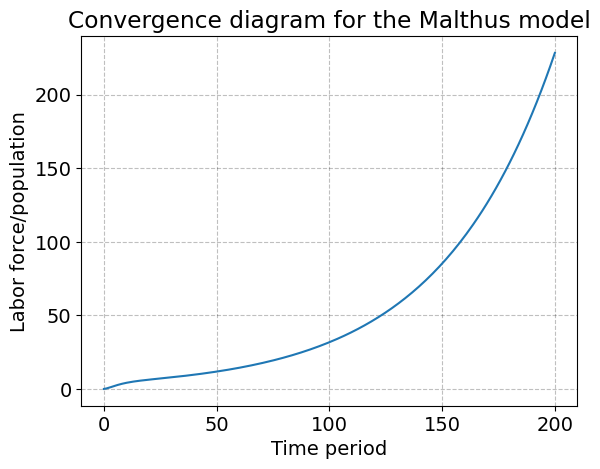

In [15]:
par.T = 200
mp.convergence_extension(par)

The prediction of the Malthus model is that population will stagnate at a constant level (and that income pr. worker will as well), which does not seem realistic given the actual development in the last decades - since the industrial revolution. Therefore, it might be more plausible (as above) to model the Malthus economy with constant growth in technology, to allow for increasing living standards and population growth.

However, an exponential growth may not be very plausible either, given that population would be predicted to grow very fast - and much faster than in reality - even for relatively low growth rates in technology. 

A more realistic extension could thus be to model less than exponential growth in technology (but still increasing), to come closer to the actual development in industrialized countries. We will, however, not go into depths with this extension here.

# Conclusion

We have seen that the simple Malthus model can be solved both analytically and numerically. We have seen that the model specification results in stagnating population size due to diminishing returns in the production function. Population will stagnate for all plausible parameter values, but for different population sizes. Hence e.g. a higher level of technology will result in a higher steady state value for population size.

If we extend the model to have exogenous techological growth however, population will not stagnate but instead continue to grow at the same rate as technology. 

Both versions of the model does not fit the actual real-world development - a better fit could maybe be to allow for less-than-exponential growth in technology.